# Training notebook for Die reorient task

We build upon the evotorch baseline which uses PGPE and ClipUp on a 2 layer RNN. Our primary approach to solving this hard exploration challenge is by using potential function based reward shaping [refer RUDDER] and task subdivision using curricula [Similar to POET]. We have a population of environments (256), each of which starts of at "easy" difficulty and adapts its difficulty level based on the success achieved by the agent in the recent past (20 episodes). The environment difficulty is controlled using the goal_rot value. Hence, the difficulty distribution is shaped by the agent's performance.

Our recently published work(At the DRL workshop in NeurIPS 2022) shows that minimizing task-irrlevant exploration speeds up learning and improves generalization. This is because visiting task-irrelevant states forces the policy/value networks to fit irrelevant targets that affect their capacity and generalization capabilities. This was also our primary motivation for entering the challenge, to verify some of our on the challenging continuous control tasks posed here.

Essentially, using a reward function based on the differences of a potential function avoids spurious optima (E.g. committing suicide) and also provides a much easier to optimize reward. (Since, it's always possible to obtain a positive reward at every state). Further, the curriculum minimizes the need for exploration and more importantly, task-irrelevant exploration making learning much faster and allowing the trained policy to generalize much better to downstream tasks in the curriculum.

# Imports
To begin with, we import all necessary tools from EvoTorch, and also PyTorch so that we can jit save the learned policy for submission.

In [2]:
from evotorch import Problem
from evotorch.algorithms import PGPE
from evotorch.neuroevolution import GymNE
from evotorch.logging import StdOutLogger, PandasLogger
import torch
import sys
import pathlib
import os

# Configuration
Now we configure for the specific environment we want to solve. We've figured this configuration out for the weighted reward keys through some trial and error, but we imagine that they can be modified further. 

In [3]:
conda_env_path = pathlib.Path(sys.executable).parent.parent
env_name = "myosuite:myoChallengeDieReorientP2-v10"
policy_path = 'agent/policies/learned_policy_reorient2_v10.pkl'
env_config = {
    'weighted_reward_keys' : {
        # 'pos_dist': 3, # We discard the provided distance based rewards.
        # 'rot_dist': 1,
        'solved': 40,
        # 'survival': 2, # We also implemented a survival reward, but we didn't need it.
        'dist_diff': -100, # We implemented the reward as a difference of a potential function
        #(In this case the sum of the pos and rot errors)
        'act_reg': 0.05,
    }
}

We configure the optimizer similar to the evotorch baseline

In [4]:
CLIPUP_MAX_SPEED = 0.15
CLIPUP_ALPHA = CLIPUP_MAX_SPEED * 0.75
RADIUS = CLIPUP_MAX_SPEED * 15

STDEV_LR = 0.1
STDEV_MAX_CHANGE = 0.2

POPSIZE = 20
POPSIZE_MAX = POPSIZE * 8
NUM_INTERACTIONS = int(POPSIZE * 200 * 0.75)
NUM_GENERATIONS = 2

### MODIFICATION: Dynamic curricula
We made a few changes to the environments to support dynamic curricula along with the potential function based reward function. However, we note that once the env reaches the maximum difficulty it is same as the original test env.

Please observe python file `reorient2_v10.py` provided along this notebook for implementation details.

### Sanity check to test that environment is importing and works correctly

In [5]:
from gym.envs.registration import register

model_path = os.path.join(
    conda_env_path, 
    *'lib/python3.8/site-packages/myosuite/envs/myo/assets/hand/myo_hand_die.mjb'.split('/')
    )
register(id='myoChallengeDieReorientP2-v10',
        entry_point='reorient2_v10:ReorientEnv2V10',
        max_episode_steps=150,
        kwargs={
            'model_path': model_path,
            'normalize_act': True,
            'frame_skip': 5,
            # Randomization in goals
            'goal_pos': (-.020, .020),  # +- 2 cm
            'goal_rot': (-0.20, 0.20),   # +-0.2 radians We start with the easiest difficulty.
            'drop_th' : 0.05, # We also reduced the drop threshold, so bad episodes are terminated early 
            # which avoids visiting task-irrelevant states and saving on sample complexity.
            #It's possible the optimal policy involves tossing the cube up, 
            # but we assume that is not the intended technique!
            'trigger_num': 20, # The number of past episodes to consider when evaluating agent performance.
            'trigger_thresh': 0.85, # The success percentage required to trigger the environment difficulty increase.
            'trigger_decay': 0.99, # We decay the success percentage as difficult environments take more timesteps to solve.
            'kappa': 0.8, # not used
            # Randomization in physical properties of the die
            'obj_size_change': 0.007, # +-7mm delta change in object size
            'obj_friction_change': (0.2, 0.001, 0.00002) # nominal: 1.0, 0.005, 0.0001
        }
    )


In [6]:
import gym
env = gym.make("myoChallengeDieReorientP2-v10")

RS:> Registering Myo Envs
Compiling /scratch/luis.ferro/conda-envs/myochallenge-iarai-jku/lib/python3.8/site-packages/mujoco_py/cymj.pyx because it changed.
[1/1] Cythonizing /scratch/luis.ferro/conda-envs/myochallenge-iarai-jku/lib/python3.8/site-packages/mujoco_py/cymj.pyx


In [7]:
env.set_difficulty(1.5, 0.98, 15)


changing goal  (-1.5, 1.5) 0.98 15


# Setup
Now we're ready to create the problem class. You should note that we're using the `Policy` class from the included `policy.py` file. In our experiments we use the same baseline 2 layer RNN policy. The recurrent layer helps because the task involves partial observability (State of tendons, randomness in objects). The use of leaky relus helps avoid capacity loss during training to an extent. Our motivation was to test our ideas on minimizing task-irrelevant exploration and hence we did not modify the policy.

In [8]:
from policy import Policy # Needs to be explicitly defined here.

problem = GymNE(
    env_name=env_name,
    env_config = env_config,
    network=Policy,
    network_args = {
        'hidden_dim': 64, # We use the same architecture used by the evotorch baseline.
    },
    observation_normalization=True,
    num_actors='max',
)
print('Solution length is', problem.solution_length)

/scratch/luis.ferro/conda-envs/myochallenge-iarai-jku/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
2023-02-24 11:29:02,913	INFO worker.py:1553 -- Started a local Ray instance.


Solution length is 21543


### Environment Registration Routine as a hook 
Here we pass the gym registration function to all environments in the population via a remote_hook

In [8]:
def register_env(problem):
    from gym.envs.registration import register
    
    print("Registering env")
    register(id='myoChallengeDieReorientP2-v10',
        entry_point='reorient2_v10:ReorientEnv2V10',
        max_episode_steps=150,
        kwargs={
            'model_path': model_path,
            'normalize_act': True,
            'frame_skip': 5,
            # Randomization in goals
            'goal_pos': (-.020, .020),  # +- 2 cm
            'goal_rot': (-0.20, 0.20),   # +-180 degrees
            'drop_th' : 0.05,
            'trigger_num': 20,
            'trigger_thresh': 0.85,
            'trigger_decay': 0.99,
            'kappa': 0.8, # not used
            # Randomization in physical properties of the die
            'obj_size_change': 0.007, # +-7mm delta change in object size
            'obj_friction_change': (0.2, 0.001, 0.00002) # nominal: 1.0, 0.005, 0.0001
        }
    )

problem.remote_hook.append(register_env)

With `problem` instantiated, we can create the searcher:

In [9]:
searcher = PGPE(
    problem,
    center_learning_rate=CLIPUP_ALPHA,
    optimizer="clipup",
    optimizer_config={"max_speed": CLIPUP_MAX_SPEED},
    radius_init=RADIUS,
    stdev_learning_rate=STDEV_LR,
    stdev_max_change=STDEV_MAX_CHANGE,
    popsize=POPSIZE,
    popsize_max=POPSIZE_MAX,
    num_interactions=NUM_INTERACTIONS,
    distributed = True,
)

We add an additional `after_step_hook` which will save the policy after every generation. This means that you can asynchonously evaluate and submit agents, even as the evolutionary run continues!

In [10]:
import torch

def save_policy():
    global problem, searcher, policy_path
    folder = pathlib.Path(policy_path).parent
    os.makedirs(folder, exist_ok=True)
    policy = problem.to_policy(searcher.status['center'])
    scripted_module = torch.jit.script(policy)
    torch.jit.save(scripted_module, policy_path)

searcher.after_step_hook.append(save_policy)

For sanity, we're adding a StdOutLogger instance and a PandasLogger instance so that we can track what's going on:

In [11]:
_ = StdOutLogger(searcher)
pandas_logger = PandasLogger(searcher)

# Train
And that's all there is to it! We're ready to train. As we go, we'll be creating `learned_policy_boading.pkl` in the local directory. Check out `README.md` to see how you can submit these learned agents. 

In [12]:
searcher.run(NUM_GENERATIONS)

(EvaluationActor pid=22220) Registering env
(EvaluationActor pid=22223) Registering env
(EvaluationActor pid=22221) Registering env
(EvaluationActor pid=22220) RS:> Registering Myo Envs
(EvaluationActor pid=22223) RS:> Registering Myo Envs
(EvaluationActor pid=22221) RS:> Registering Myo Envs
(EvaluationActor pid=22222) Registering env
(EvaluationActor pid=22222) RS:> Registering Myo Envs


(EvaluationActor pid=22222) /scratch/luis.ferro/myo/conda-env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
(EvaluationActor pid=22222)   return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
(EvaluationActor pid=22220) /scratch/luis.ferro/myo/conda-env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
(EvaluationActor pid=22220)   return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
(EvaluationActor pid=22221) /scratch/luis.ferro/myo/co

     iter : 1
mean_eval : 202.79705047607422

     iter : 2
mean_eval : 215.78834533691406



Finally, it's nice to see the mean evaluation of the training as time passes. You can interrupt the above cell at any time, generate the plot below, and restart the above cell to continue training!

<AxesSubplot: xlabel='iter'>

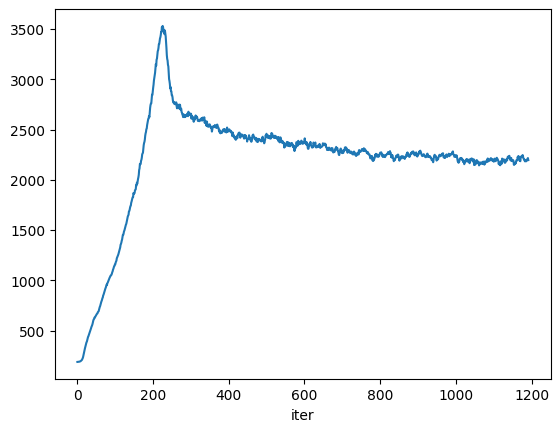

In [21]:
pandas_logger.to_dataframe().mean_eval.plot()